# Measuring the cross correlation of the HCDs with the Ly$\alpha$ forest

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import Corrfunc
from Corrfunc.theory.xi import xi
from Corrfunc.theory.DD import DD
from scipy.optimize import minimize


In [2]:
fname_on='/data/desi/common/astrid/spectra_ASTRID_z2.5_500x500x2500.hdf5'

In [3]:
with h5py.File(fname_on,'r') as f:
    tau_on = f['tau/H/1/1215'][:]
    colden = f['colden']['H/1'][:]
    axes = f['spectra/axes'][:]
    # (x,y,z) start of the skewers, in kpc/h
    cofm_hkpc = f['spectra/cofm'][:]

In [4]:
L_hMpc=250
Nsk=int(np.sqrt(colden.shape[0]))
Np=int(colden.shape[1])
dz_hMpc=L_hMpc/Np
dxy_hMpc=L_hMpc/Nsk
max_colden=np.max(colden.reshape([Nsk,Nsk,Np]),axis=2)
def skewer_index(ix, iy):
    return ix*Nsk+iy

In [5]:
def HCDs_coords(mincolden, maxcolden):  
    
    coordinates = {
    "x": np.array([]),
    "y": np.array([]),
    "z": np.array([])
    }
   
    for i in range(Nsk):
        for j in range(Nsk):
            if mincolden < max_colden[i][j] < maxcolden:
                coordinates["x"] = np.append(coordinates["x"], dxy_hMpc*i)
                coordinates["y"] = np.append(coordinates["y"], dxy_hMpc*j)
    for i in range(max(len(coordinates["x"]), len(coordinates["y"]))):
        coordinates["z"] = np.append(coordinates["z"], dz_hMpc*np.argmax(tau_on[int(skewer_index(coordinates["x"][i],coordinates["y"][i]))]))
    return coordinates

In [6]:
coords_Lya = HCDs_coords(0, 1.6e17)
coords_HCDs = HCDs_coords(1.6e17, 1e25)
coords_tot = HCDs_coords(0, 1e25)

In [7]:
binf = np.logspace(np.log10(2), np.log10(20), 10)
func_Lya = Corrfunc.theory.xi(boxsize=250.0, nthreads=1, binfile=binf, X=coords_Lya["x"],Y=coords_Lya["y"],Z=coords_Lya["z"], output_ravg=True)
func_HCDs = Corrfunc.theory.xi(boxsize=250.0, nthreads=1, binfile=binf, X=coords_HCDs["x"],Y=coords_HCDs["y"],Z=coords_HCDs["z"], output_ravg=True)
func_tot = Corrfunc.theory.xi(boxsize=250.0, nthreads=1, binfile=binf, X=coords_tot["x"],Y=coords_tot["y"],Z=coords_tot["z"], output_ravg=True)
func_cross = Corrfunc.theory.DD(autocorr = 0, boxsize=250.0, nthreads=1, binfile=binf, X1=coords_Lya["x"], Y1=coords_Lya["y"], Z1=coords_Lya["z"], X2=coords_HCDs["x"], Y2=coords_HCDs["y"], Z2=coords_HCDs["z"], output_ravg=True)

In [8]:
func_LyaDD = Corrfunc.theory.DD(autocorr = 1, boxsize=250.0, nthreads=1, binfile=binf, X1=coords_Lya["x"], Y1=coords_Lya["y"], Z1=coords_Lya["z"], output_ravg=True)
#Line for validation (not used)

In [9]:
vol = 4/3*np.pi*(func_cross["rmax"]**3-func_cross["rmin"]**3)
vol_box = L_hMpc**3
n_Lya = len(coords_Lya["x"])
n_HCDs = len(coords_HCDs["x"])

In [10]:
xi_LyaDD = ((func_LyaDD["npairs"] * vol_box) / (vol * n_Lya**2)) - 1
#Line for validation (not used)

In [11]:
xi_cross = ((func_cross["npairs"] * vol_box) / (vol * n_Lya * n_HCDs)) - 1

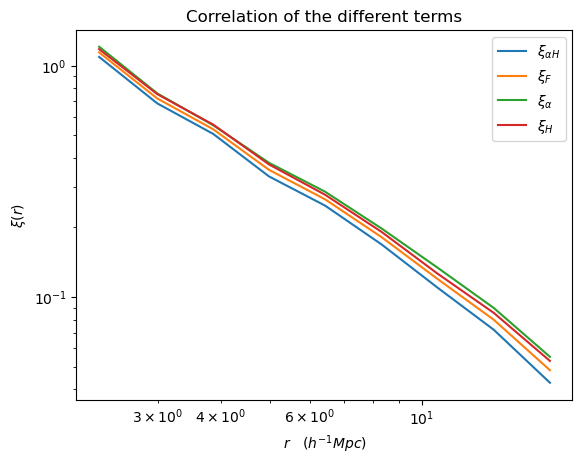

In [12]:
plt.plot(func_cross["ravg"], xi_cross, label = r"$\xi_{\alpha H}$")
#plt.plot(func_LyaDD["ravg"], xi_LyaDD, "--", label = r"test")
plt.plot(func_tot["ravg"], func_tot["xi"],  label = r"$\xi_{F}$")
plt.plot(func_Lya["ravg"], func_Lya["xi"],  label = r"$\xi_{\alpha}$")
plt.plot(func_HCDs["ravg"], func_HCDs["xi"], label = r"$\xi_{H}$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("Correlation of the different terms")
plt.xlabel(r"$r\quad(h^{-1}Mpc)$")
plt.ylabel(r"$\xi(r)$")
plt.savefig("diferent_terms.png")
plt.show()

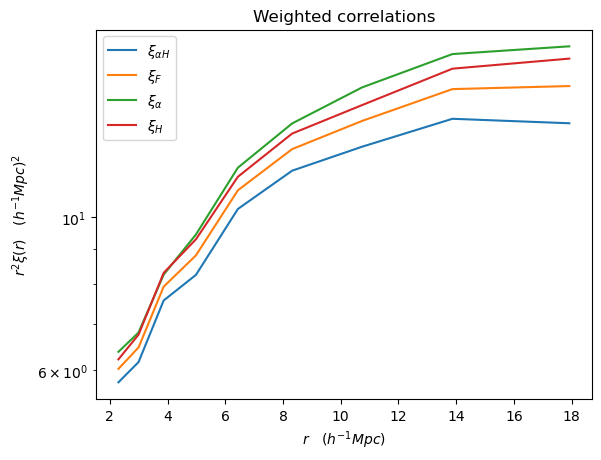

In [13]:
plt.plot(func_cross["ravg"], func_cross["ravg"]**2 * xi_cross, label = r"$\xi_{\alpha H}$")
#plt.plot(func_LyaDD["ravg"], xi_LyaDD, "--", label = r"test")
plt.plot(func_tot["ravg"], func_tot["ravg"]**2 * func_tot["xi"],  label = r"$\xi_{F}$")
plt.plot(func_Lya["ravg"], func_Lya["ravg"]**2 * func_Lya["xi"],  label = r"$\xi_{\alpha}$")
plt.plot(func_HCDs["ravg"], func_HCDs["ravg"]**2 * func_HCDs["xi"], label = r"$\xi_{H}$")
plt.yscale("log")
plt.legend()
plt.title("Weighted correlations")
plt.xlabel(r"$r\quad(h^{-1}Mpc)$")
plt.ylabel(r"$r^{2}\xi(r)\quad(h^{-1}Mpc)^{2}$")
plt.show()

## Calculate the optimal value for C ignoring 3pcf terms

In [14]:
func_Lya_2 = np.interp(func_tot["ravg"], func_Lya["ravg"], func_Lya["xi"])
func_HCDs_2 = np.interp(func_tot["ravg"], func_HCDs["ravg"], func_HCDs["xi"])
func_cross_2 = np.interp(func_tot["ravg"], func_cross["ravg"], xi_cross)

In [15]:
def f(x):
    s = np.sum(((1 / (1 + x)**2) * (1 + 2*x + func_Lya_2 + 2*func_cross_2 + func_HCDs_2) - func_tot["xi"] - 1)**2)
    return s
result = minimize(f, 0)

In [16]:
C = result.x

In [17]:
minimize(f, 0)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.13707221151018856
        x: [ 7.462e-01]
      nit: 7
      jac: [-2.738e-07]
 hess_inv: [[ 5.484e-02]]
     nfev: 20
     njev: 10

## Compare the two point model with the total correlation

In [18]:
p2_model = (1 / (1 + C)**2) * (1 + 2*C + func_Lya_2 + 2*func_cross_2 + func_HCDs_2)

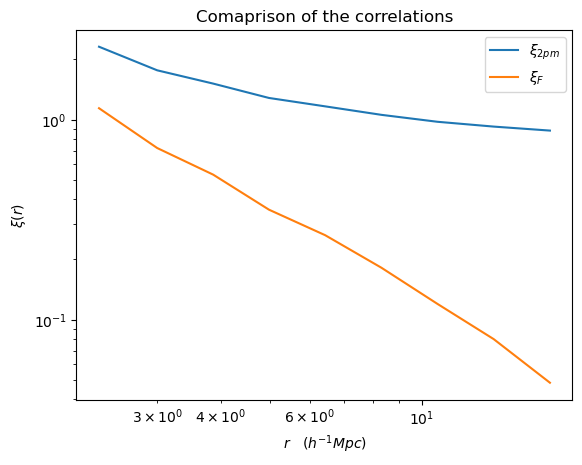

In [19]:
plt.plot(func_tot["ravg"], p2_model,  label = r"$\xi_{2pm}$")
plt.plot(func_tot["ravg"], func_tot["xi"],  label = r"$\xi_{F}$")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.title("Comaprison of the correlations")
plt.xlabel(r"$r\quad(h^{-1}Mpc)$")
plt.ylabel(r"$\xi(r)$")
plt.savefig("model.png")
plt.show()

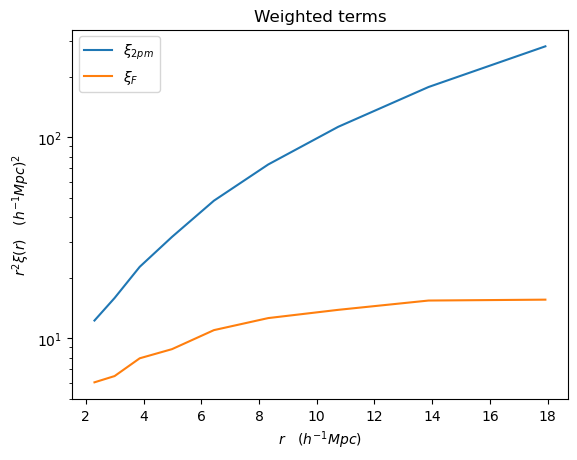

In [20]:
plt.plot(func_tot["ravg"], func_tot["ravg"]**2 * p2_model,  label = r"$\xi_{2pm}$")
plt.plot(func_tot["ravg"], func_tot["ravg"]**2 * func_tot["xi"],  label = r"$\xi_{F}$")
plt.yscale("log")
plt.legend()
plt.title("Weighted terms")
plt.xlabel(r"$r\quad(h^{-1}Mpc)$")
plt.ylabel(r"$r^{2}\xi(r)\quad(h^{-1}Mpc)^{2}$")
plt.show()